In [ ]:
!pip install tensorflow==2.16.1
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models
!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from time import time
import numpy as np
import random as python_random
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/Progetto DeepL/train_imgs_2D (1).npy'
train_mask_path = '/content/gdrive/MyDrive/Colab Notebooks/Progetto DeepL/train_labels_2D (1).npy'
val_dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/Progetto DeepL/validation_imgs_2D (1).npy'
val_mask_path = '/content/gdrive/MyDrive/Colab Notebooks/Progetto DeepL/validation_labels_2D (1).npy'

X_train = np.load(train_dataset_path)
Y_train = np.load(train_mask_path)
X_val = np.load(val_dataset_path)
Y_val = np.load(val_mask_path)

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 0.0001
  class_num = 4
  for i in range(class_num):
    y_true_f = tf.nest.flatten(y_true[:,:,:, i])
    y_pred_f = tf.nest.flatten(y_pred[:,:, :, i])
    intersection = tf.reduce_sum([y_true_f[i] * y_pred_f[i] for i in range(len(y_true_f))])
    loss = ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
    if i == 0:
      total_loss = loss
    else:
      total_loss = total_loss + loss
  total_loss = total_loss / class_num
  return total_loss

def dice_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)


In [ ]:
def conv_block_down(inputs, filters):
    x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    p = keras.layers.MaxPool2D((2, 2))(x)

    return x, p


In [ ]:
def conv_central(inputs, filters):
    x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    return x

In [ ]:
def conv_block_up(inputs, filters):

  x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  x = keras.layers.Conv2D(filters, strides=(1,1), kernel_size = (3,3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  return x


In [ ]:
input = keras.Input(shape=(128,128,4))


#aug2 = keras.layers.RandomRotation(factor = (-0.1, 0.1))(input)

x1, p1 = conv_block_down(input, 8)
x2, p2 = conv_block_down(p1, 12)
x3, p3 = conv_block_down(p2, 32)
x4, p4 = conv_block_down(p3, 64)


x6 = conv_central(p4, 128)

u1 = keras.layers.UpSampling2D((2, 2))(x6)
conc1 = keras.layers.Concatenate()([u1, x4])
x8 = conv_block_up(conc1, 64)
u2 = keras.layers.UpSampling2D((2, 2))(x8)
conc2 = keras.layers.Concatenate()([u2, x3])
x9 = conv_block_up(conc2, 32)
u3 = keras.layers.UpSampling2D((2, 2))(x9)
conc3 = keras.layers.Concatenate()([u3, x2])
x10 = conv_block_up(conc3, 16)
u4 = keras.layers.UpSampling2D((2, 2))(x10)
conc4 = keras.layers.Concatenate()([u4, x1])
x11 = conv_block_up(conc4, 8)

dropout = keras.layers.Dropout(rate=0.4)(x11)
out = keras.layers.Conv2DTranspose(4, strides=(1,1), kernel_size = (1,1), padding='same', activation='softmax')(x11)

model = keras.Model(input, out)


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=segmentation_models.losses.DiceLoss(), metrics=[segmentation_models.metrics.FScore(), segmentation_models.metrics.IOUScore()])

In [ ]:

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
             ]

In [ ]:
history = model.fit(x=X_train, y= Y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, Y_val), callbacks=[callbacks])

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 272ms/step - f1-score: 0.3393 - iou_score: 0.2371 - loss: 0.6607 - val_f1-score: 0.2680 - val_iou_score: 0.1915 - val_loss: 0.7320
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - f1-score: 0.6557 - iou_score: 0.5227 - loss: 0.3443 - val_f1-score: 0.5196 - val_iou_score: 0.4269 - val_loss: 0.4803
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - f1-score: 0.7595 - iou_score: 0.6343 - loss: 0.2405 - val_f1-score: 0.5635 - val_iou_score: 0.4719 - val_loss: 0.4364
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - f1-score: 0.7991 - iou_score: 0.6827 - loss: 0.2009 - val_f1-score: 0.6001 - val_iou_score: 0.5120 - val_loss: 0.3998
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - f1-score: 0.8131 - iou_score: 0.7006 - loss: 0.1869 - val_f1-score: 0.6769 - val_iou_score: 0.5756 - val_loss: 0.3230
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - f1-score: 0.8308 - iou_score: 0.7238 - loss: 0.1692 - val_f1-score: 0.639

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 5,900,238 (22.51 MB)

 Trainable params: 1,965,764 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 3,931,530 (15.00 MB)

<Figure size 500x800 with 0 Axes>

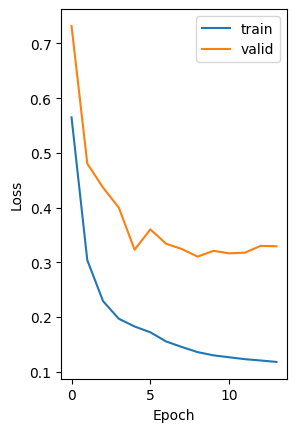

<Figure size 500x800 with 0 Axes>

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.figure(figsize = (5,8))


<Figure size 500x800 with 0 Axes>

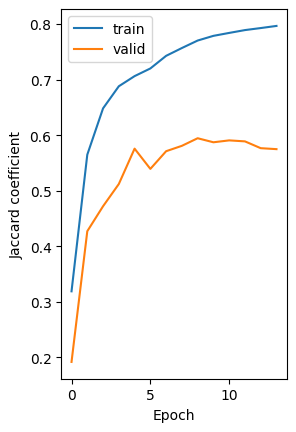

<Figure size 500x800 with 0 Axes>

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.xlabel('Epoch')
plt.ylabel('Jaccard coefficient')
plt.legend(['train', 'valid'])
plt.figure(figsize = (5,8))

<Figure size 500x800 with 0 Axes>

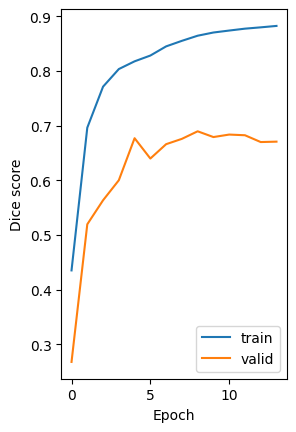

<Figure size 500x800 with 0 Axes>

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.legend(['train', 'valid'])
plt.figure(figsize = (5,8))

In [ ]:
train_loss = history.history['loss'][-1]
train_acc = history.history['iou_score'][-1]
train_dice = history.history['f1-score'][-1]

val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_iou_score'][-1]
val_dice = history.history['val_f1-score'][-1]

import pandas as pd

row1 = {'Loss': train_loss, 'Jaccard coefficient': train_acc, 'F1 score': train_dice}
row2 = {'Loss': val_loss, 'Jaccard coefficient': val_acc, 'F1 score': val_dice}
rows = [row1, row2]

metrics_table = pd.DataFrame(rows, index=['Train', 'Validation'])
metrics_table

,Loss,Jaccard coefficient,F1 score
Train,0.117860,0.796709,0.882141
Validation,0.329234,0.574759,0.670616


In [ ]:
epochs_table = pd.DataFrame()
epochs_table['Loss'] = history.history['loss']
epochs_table['Validation Loss'] = history.history['val_loss']
epochs_table['Jaccard'] = history.history['iou_score']
epochs_table['Validation Jaccard'] = history.history['iou_score']
epochs_table['Dice score'] = history.history['f1-score']
epochs_table['Validation Dice score'] = history.history['val_f1-score']

epochs_table

,Loss,Validation Loss,Jaccard,Validation Jaccard,Dice score,Validation Dice score
0,0.564939,0.731990,0.318669,0.318669,0.435253,0.267979
1,0.303929,0.480321,0.564817,0.564817,0.696154,0.519562
2,0.228946,0.436425,0.648238,0.648238,0.771108,0.563456
3,0.196743,0.399789,0.688040,0.688040,0.803289,0.600063
4,0.182611,0.322963,0.706282,0.706282,0.817420,0.676897
5,0.172017,0.360095,0.720098,0.720098,0.828000,0.639754
6,0.155273,0.333891,0.742830,0.742830,0.844745,0.665974
7,0.145133,0.324155,0.756890,0.756890,0.854884,0.675727
8,0.135767,0.310354,0.770378,0.770378,0.864243,0.689527
9,0.129914,0.320881,0.778832,0.778832,0.870096,0.679004


In [ ]:
model.save('model_no_dropout.h5')
model.save_weights('model_no_dropout.weights.h5')

In [ ]:
metrics_table.to_csv('train_validation_metrics')
epochs_table.to_csv('train_epochs.csv')